# How to use MutexWatershed

#### Since this tutorial takes place in a colab notebook we will have to install conda first. If you follow this locally you should instead install conda/miniconda (see https://docs.conda.io/en/latest/miniconda.html)

In [0]:
!wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
!chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
!bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')
import affogato

Also we will download some precomputed affinities:

In [0]:
!rm download*
!wget https://hcicloud.iwr.uni-heidelberg.de/index.php/s/K6HBFi7Nr5rCuIA/download
!mv download isbi_test_affinities.h5

# Installation

You can simply install the affogato library from conda (omit the prefix flag if you are outside of a colab notebook)

In [0]:
!conda install -q -y --prefix /usr/local -c cpape -c conda-forge affogato

## Running MutexWatershed on your data



### Loading affinities


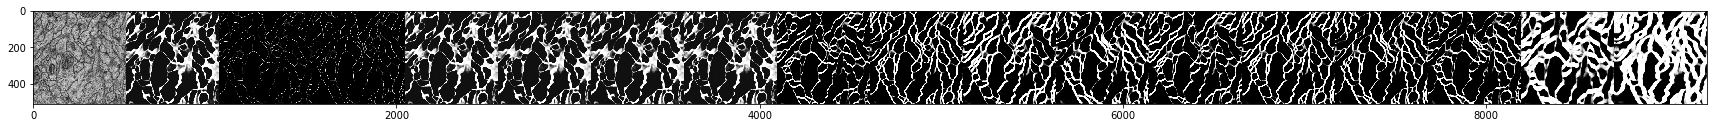

In [38]:
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

with h5py.File("isbi_test_affinities.h5", "r") as infile:
  raw = infile["raw"][:]
  affinities = infile["affinities"][:]

fig = plt.figure(figsize=(30,10))
plt.imshow(np.concatenate((raw[4], ) + tuple(affinities[c, 4] for c in range(len(affinities))), axis=1), cmap='gray')



Theses affinities correspond to the following offsets

In [0]:
offsets = [[-1, 0, 0], [0, -1, 0], [0, 0, -1],
           # direct 3d nhood for attractive edges
           [-1, -1, -1], [-1, 1, 1], [-1, -1, 1], [-1, 1, -1],
           # indirect 3d nhood for dam edges
           [0, -9, 0], [0, 0, -9],
           # long range direct hood
           [0, -9, -9], [0, 9, -9], [0, -9, -4], [0, -4, -9], [0, 4, -9], [0, 9, -4],
           # inplane diagonal dam edges
           [0, -27, 0], [0, 0, -27]]

### Repulsive graph weights

Emprically, we have found that a combination of short-range attractive and long-range repulsive edges yields the best performance on our datasets.
Therefore we will transform the affinities to repulsive and attractive weights

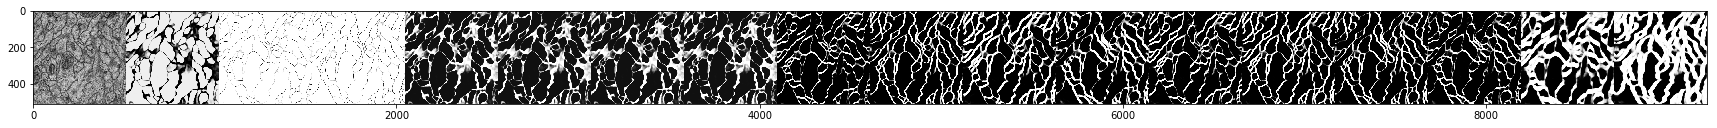

In [66]:
attractive_repuslive_weights = affinities.copy()

seperating_channel = 3
attractive_repuslive_weights[:seperating_channel] *= -1
attractive_repuslive_weights[:seperating_channel] += +1

fig = plt.figure(figsize=(30,10))
plt.imshow(np.concatenate((raw[4], ) + tuple(attractive_repuslive_weights[c, 4] for c in range(len(attractive_repuslive_weights))), axis=1), cmap='gray')

## Run Mutex Watershed

Now let's run the MWS. Note that we can influence the runtime of the algorithm by using only a subset of repulsive edges. To this end we set strides=[1, 10, 10].

In [0]:
from affogato.segmentation import compute_mws_segmentation

seg = compute_mws_segmentation(attractive_repuslive_weights, offsets, seperating_channel, strides=[1, 10, 10])

That's it!

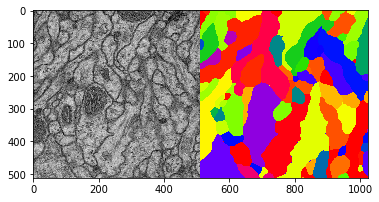

In [74]:
from matplotlib import cm
show_raw = cm.gray(raw[4])
show_seg = cm.prism(seg[4] / seg[4].max())
plt.imshow(np.concatenate((show_raw, show_seg, ), axis=1)) 